In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad, quad
import time
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
from scipy.special import iv






 63%|██████████████████████████▍               | 63/100 [20:11<11:51, 19.22s/it]





 16%|██████▋                                   | 16/100 [00:00<00:01, 48.89it/s]/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/h7/_hqqwrk517z46v06lptyq1580000gn/T/ipykernel_79630/1323120554.py:24: RuntimeWarning: invalid value encountered in scalar add
/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/leonardocardinale/opt/miniconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: inval

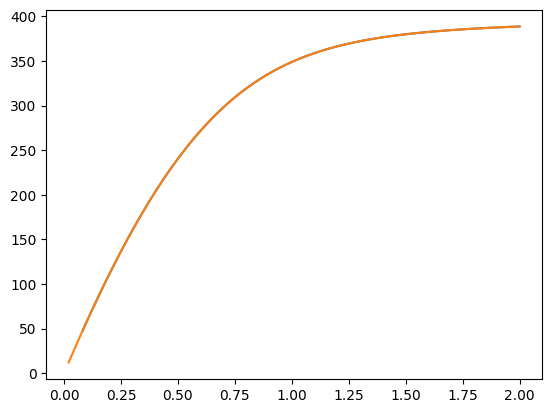

In [32]:
def fourier_exact(beta,N,n,max_iter=100):
    if N == 1:
        return iv(n,2*beta) * np.exp(-2*N*beta)
    else:
        s = 0
        for l in range(max_iter):
            arr = np.zeros((N,N))
            for i in range(N):
                for j in range(N):
                    if i in range(N-1):
                        arr[i,j] = iv(l+j-i+n[i],2*beta)
                    else:
                        arr[i,j] = iv(l+j-i,2*beta)
            if l == 0:
                s += np.linalg.det(arr)
            else:
                arr1 = np.zeros((N,N))
                for i in range(N):
                    for j in range(N):
                        if i in range(N-1):
                            arr1[i,j] = iv(-l+j-i+n[i],2*beta)
                        else:
                            arr1[i,j] = iv(-l+j-i,2*beta)
                s += (np.linalg.det(arr) + np.linalg.det(arr1))
        return s * np.exp(-2*N*beta)
    
def Z_U1(beta,num=10,cutoff=10):
    res = fourier_exact(beta,1,0)**(num**2)
    for r in range(1,cutoff):
        res += 2 * fourier_exact(beta,1,r)**(num**2)
    return res

def Z_SU2(beta,num=10,cutoff=10):
    res = 0
    for r in range(cutoff):
        res += (fourier_exact(beta,2,[r])/(r+1))**(num**2)
    return res

def Z_SU3(beta,num=10,cutoff=10):
    res = 0
    for p in range(cutoff):
        for q in range(cutoff):
            dim = (p+1) * (q+1) * (p+q+2)/2
            res += (fourier_exact(beta,3,[p,q])/dim)**(num**2)
    return res

def Z_test(beta,num=10,cutoff=10):
    res = 0
    for p in range(1,cutoff):
        for q in range(1,cutoff):
            dim = p * q * (p+q)/2
            res += (coeff(beta,p,q)/dim)**(num**2)
    return res

def char_aux(p,q,A,B):
    term1 = np.exp(1j*p*A-1j*q*B) - np.exp(-1j*q*A+1j*p*B)
    term2 = np.exp(-1j*p*(A+B)) * (np.exp(-1j*q*A)-np.exp(-1j*q*B))
    term3 = np.exp(1j*q*(A+B)) * (np.exp(1j*p*B)-np.exp(1j*p*A))
    return -1j * (term1 + term2 + term3)

def plaq(beta,A,B):
    vp1, vp2, vp3 = np.exp(1j*A), np.exp(1j*B), np.exp(1j*(-A-B))
    return np.exp(2*beta*np.real((vp1+vp2+vp3-3)))

def s_(A,B):
    return 8*np.sin(0.5*(A-B))*np.sin(0.5*(A+2*B))*np.sin(0.5*(2*A+B))

def coeff(beta,p,q):
    rea = nquad(lambda A,B:np.real(plaq(beta,A,B) * np.conj(char_aux(p,q,A,B)) * s_(A,B)/ (24*np.pi**2)),[[-np.pi,np.pi],[-np.pi,np.pi]])[0]
    imagi = nquad(lambda A,B:np.imag(plaq(beta,A,B) * np.conj(char_aux(p,q,A,B)) * s_(A,B)/ (24*np.pi**2)),[[-np.pi,np.pi],[-np.pi,np.pi]])[0]
    return rea + 1j * imagi

coeff_vec = np.vectorize(coeff)

def Z_test(beta,num=10):
    s = 0
    p = np.arange(1,6)
    q = np.arange(1,6)
    P,Q = np.meshgrid(p,q)
    d = 1/2 * P * Q * (P + Q)
    arr = (1/d * coeff_vec(beta,P,Q))**(num**2)
    return np.real(np.sum(arr))

num_cores = multiprocessing.cpu_count()
betas = np.linspace(0, 2, 100)

with Parallel(n_jobs=num_cores) as parallel:
    Z_list = parallel(delayed(Z_SU3)(beta) for beta in tqdm(betas))
    Z_list2 = parallel(delayed(Z_test)(beta) for beta in tqdm(betas))

plt.plot(betas[1::],- betas[1::] * np.diff(np.log(Z_list))/np.diff(betas))
plt.plot(betas[1::],- betas[1::] * np.diff(np.log(Z_list2))/np.diff(betas))

In [25]:
(- betas[1::] * np.diff(np.log(Z_list))/np.diff(betas))[-1]

388.64784826710587